In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import uuid
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

In [2]:
cwd = os.getcwd()

In [3]:
cwd

'/home/kumar.amit1/ondemand/data/sys/myjobs/projects/default/1/data'

In [4]:
POS_PATH ='data_crop/positive_crop'
NEG_PATH ='data_crop/negative_crop'
ANC_PATH ='data_crop/anchor_crop'

# Loading and Processing Image

In [5]:
# Get Image directory
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)

2023-04-25 22:24:44.706003: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 22:24:45.519464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 77292 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:bd:00.0, compute capability: 8.0


In [6]:
# Sacle and Resize
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (300,300))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

# Creating Labels

In [7]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [8]:
samples = data.as_numpy_iterator()

In [9]:
exampple = samples.next()
print(exampple)

(b'data_crop/anchor_crop/RE2222.jpg', b'data_crop/positive_crop/RE326.jpg', 1.0)


# Train and Test Partiton

In [10]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

1.0


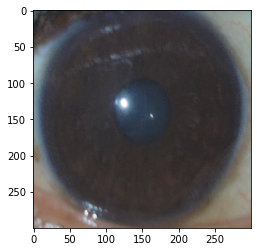

In [11]:
res = preprocess_twin(*exampple)
plt.imshow(res[1])
print(res[2])

In [12]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [13]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [14]:
#Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8) 

# Model Engineering

## Embedding Model

In [15]:
def form_embedding():
    #Input Layer
    inputlayer = Input(shape=(300,300,3), name='input_image')
    
    #First layer
    c1 = Conv2D(64, (10,10), activation='relu')(inputlayer)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second layer
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third Layer
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
 
    #Final layer
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inputlayer], outputs=[d1], name='embedding')
    

In [16]:
embedding=form_embedding()

## distance Layer

In [17]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## Siamese network

In [18]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(300,300,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(300,300,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    #distances = siamese_layer(embedding_efB4(input_image), embedding_efB4(validation_image))
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [19]:
siamese_model = make_siamese_model()

In [20]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         1008893248  input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

# Training

In [21]:
# Loss and Optimier
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [22]:
# establish checkpoint
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [23]:
# Train Step Function
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [24]:
# Training Loop
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## Train The model

In [25]:
EPOCHS = 5

In [26]:
train(train_data, EPOCHS)


 Epoch 1/5


2023-04-25 22:24:46.997862: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-25 22:24:56.998202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 785 of 10000
2023-04-25 22:24:57.633292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


2023-04-25 22:24:58.944432: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2023-04-25 22:24:59.986253: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Running ptxas --version returned 32512
2023-04-25 22:25:00.074473: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-25 22:25:01.890914: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


45/45 [==============================] - 48s 665ms/step
0.021557642 0.9854651 0.96033996

 Epoch 2/5
45/45 [==============================] - 29s 634ms/step
0.043293778 1.0 1.0

 Epoch 3/5
45/45 [==============================] - 29s 633ms/step
1.2546935e-05 0.9971671 0.9971671

 Epoch 4/5
45/45 [==============================] - 28s 627ms/step
0.0017192084 0.99712646 0.9942693

 Epoch 5/5
45/45 [==============================] - 28s 615ms/step
0.0038640506 0.9941691 0.98554915


## Evaluating Model

In [27]:
# Batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])

In [28]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]
print(y_true)

[1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1.]


## Comparision Matrix 

In [29]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [30]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1.0 1.0


# Result

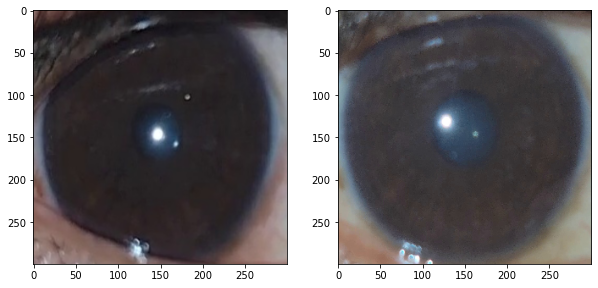

In [31]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[5])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[5])

# Renders cleanly
plt.show()

# Save Model

In [ ]:
#Save model weights
#siamese_model.save('siamesemodelv2.h5')

2023-04-25 22:27:33.489992: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [ ]:
# Reload model 
#siamese_model_predict = tf.keras.models.load_model('siamesemodelv2.h5',custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
#siamese_model.predict([test_input, test_val])